In [8]:
import pandas as pd
import tensorflow as tf
import numpy as np
import os
import contractions
import re
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences

In [ ]:
!pip install contractions

Text(0.5, 1.0, 'Distribution of labels')

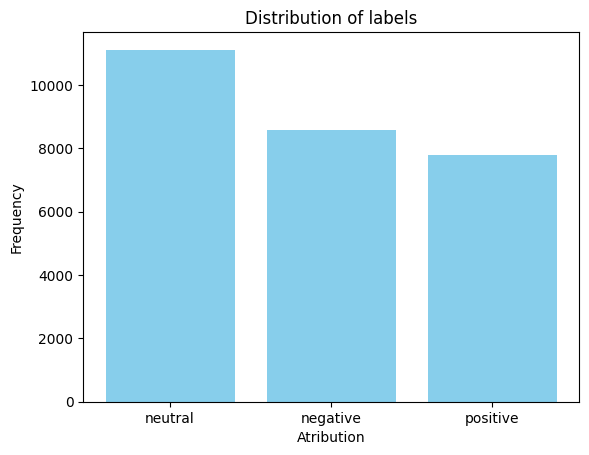

In [9]:
#Read the data from csv file
data = pd.read_csv('/kaggle/input/sentiment-analysis-dataset/train.csv', encoding = 'ISO-8859-1')
data = data.dropna(subset='text')
x = data['sentiment'].unique()
y = data['sentiment'].value_counts().values

#Plot data to see the distribution of labels
plt.bar(x, y, color='skyblue')
plt.xlabel('Atribution')
plt.ylabel('Frequency')
plt.title('Distribution of labels')

In [10]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
from nltk.corpus import wordnet

In [12]:
sentiment = data['sentiment'].values.reshape(-1, 1)
sentiment

array([['neutral'],
       ['negative'],
       ['negative'],
       ...,
       ['positive'],
       ['positive'],
       ['neutral']], dtype=object)

In [39]:
#Using one-hot to transform text labels into numbers
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
encoded_labels = encoder.fit_transform(sentiment)
pd.DataFrame(encoded_labels, columns = encoder.get_feature_names_out())

,x0_negative,x0_neutral,x0_positive
0,0.0,1.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
...,...,...,...
27475,1.0,0.0,0.0
27476,1.0,0.0,0.0
27477,0.0,0.0,1.0
27478,0.0,0.0,1.0


In [14]:
#List all the most common words but almost quite useless for predicting the labels
stopword = stopwords.words('english') #179
len(stopword)
text_data = data['text'].values
stopword

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [15]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
#Reformat the text data to remove the unimportant part
def clean(text):
    text = re.sub(r'[^a-zA-Z\s]', '', str(text))
    # Conver to lower
    text = text.lower()
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    text_list = [x for x in text.split() if x not in stopword]
    text = ' '.join(text_list)
    return text

In [ ]:
clean_data = []
for x in text_data:
    x_fixed = clean(x)
    clean_data.append(x_fixed)
clean_data

In [18]:
collected_words = []
for x in clean_data:
    collected_words.extend(x.split())
len(collected_words)

198454

In [ ]:
#Turn words into numeric data using word embedding
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_data)
z = tokenizer.texts_to_sequences(clean_data)
z
max_len = max([len(y) for y in z])
padding_sequence = pad_sequences(z, maxlen=max_len)
voc_size = len(tokenizer.word_index)
#padding the sequence: make sure the inputs are in the same length
print(z)

In [20]:
#Train-test-split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padding_sequence, encoded_labels, test_size= 0.25, random_state=42)
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)


In [21]:
from tensorflow import keras
from keras.models import Sequential

from keras import layers
from keras.models import Model
from keras.layers import SimpleRNN, LSTM, Bidirectional, GRU
from keras.layers import Input, MultiHeadAttention, Attention, AdditiveAttention

from keras.layers import Embedding, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [22]:
#Custom the optimizers with learning rate decay, just in case 
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=2,
    decay_rate=0.96,
    staircase=True  # If True, learning rate decays at discrete intervals
)

In [23]:
#Custom the model with all the kind of RNN models, testing to choose which is the best model to use
type = ['RNN', 'LSTM', 'BiLSTM', 'GRU', 'BiGRU']
from tensorflow.keras import regularizers
def model_creation(model_type, vocab_size, embed_dim):
    model = Sequential()
    model.add(Embedding(vocab_size, embed_dim))
    
    if model_type == 'RNN':
        model.add(SimpleRNN(32, return_sequences=True))
    elif model_type == 'LSTM':
        model.add(LSTM(32, return_sequences=True))
    elif model_type == 'GRU':
        model.add(GRU(32, return_sequences=True))
    elif model_type == 'BiLSTM':
        model.add(Bidirectional(LSTM(32, return_sequences=True)))
    elif model_type == 'BiGRU':
        model.add(Bidirectional(GRU(32, return_sequences=True)))
    model.add(BatchNormalization())
    
    if model_type == 'RNN':
        model.add(SimpleRNN(64, kernel_regularizer=regularizers.l2(0.001)))
    elif model_type == 'LSTM':
        model.add(LSTM(64, kernel_regularizer=regularizers.l2(0.001)))
    elif model_type == 'GRU':
        model.add(GRU(64, kernel_regularizer=regularizers.l2(0.001)))
    elif model_type == 'BiLSTM':
        model.add(Bidirectional(LSTM(64, kernel_regularizer=regularizers.l2(0.001))))
    elif model_type == 'BiGRU':
        model.add(Bidirectional(GRU(64, kernel_regularizer=regularizers.l2(0.001))))

    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation = 'softmax'))
    return model


In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import EarlyStopping
checkpoint = ModelCheckpoint(
    'best_model.keras',              # Path where the model will be saved
    monitor='val_loss',           # Metric to monitor
    save_best_only=True,           # Save only the best model
    mode='min',                   # Mode for the monitored metric (min for loss)
    verbose=1                     # Verbosity mode (0 or 1)
)
csv_logger = CSVLogger('training_log.csv', separator=',', append=True)

In [25]:
for model_type in type:
    early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    print(f"Model type: {model_type}")
    model = model_creation(model_type, voc_size + 1, 128)
    opt = tf.keras.optimizers.Adam(0.0001)
    model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
    model.fit(X_train, y_train, epochs = 5, validation_data=(X_test, y_test), callbacks=early_stopping)
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"Accuracy: {accuracy}, loss: {loss}")


Model type: RNN
Epoch 1/5
 27/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3660 - loss: 1.2732

I0000 00:00:1723270712.984124     594 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


645/645 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.3850 - loss: 1.2122 - val_accuracy: 0.4429 - val_loss: 1.1033
Epoch 2/5
645/645 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6640 - loss: 0.8339 - val_accuracy: 0.5476 - val_loss: 1.0175
Epoch 3/5
645/645 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8098 - loss: 0.5862 - val_accuracy: 0.6015 - val_loss: 0.9173
Epoch 4/5
645/645 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8861 - loss: 0.4201 - val_accuracy: 0.6230 - val_loss: 0.9354
Epoch 5/5
645/645 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9270 - loss: 0.2982 - val_accuracy: 0.6250 - val_loss: 1.0061
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6042 - loss: 0.9161
Accuracy: 0.6014556288719177, loss: 0.9172655344009399
Model type: LSTM
Epoch 1/5
645/645 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.4461 - loss: 1.1133 - val_accuracy: 0.5920 - val_loss: 0.9364
Epoch 2/5
645/645 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.7114 - loss: 0.7561 - val_accur

In [55]:
#Choose the LSTM model, run it again
model = model_creation('LSTM', voc_size + 1, 128)
opt = tf.keras.optimizers.Adam(0.0001)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
model.fit(X_train, y_train, epochs = 5, validation_data=(X_test, y_test), callbacks=early_stopping)

Epoch 1/5
645/645 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.4546 - loss: 1.1079 - val_accuracy: 0.5911 - val_loss: 0.9301
Epoch 2/5
645/645 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.7144 - loss: 0.7460 - val_accuracy: 0.6464 - val_loss: 0.8574
Epoch 3/5
645/645 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8202 - loss: 0.5378 - val_accuracy: 0.6544 - val_loss: 0.8781
Epoch 4/5
645/645 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.8938 - loss: 0.3778 - val_accuracy: 0.6124 - val_loss: 1.0327


In [56]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy: {accuracy}, loss: {loss}")

215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6554 - loss: 0.8478
Accuracy: 0.6464337706565857, loss: 0.85738605260849


In [58]:
#Use the model to predict
def prediction(predicted_text):
    changed_text = [clean(x) for x in predicted_text]
    formatted_text = tokenizer.texts_to_sequences(changed_text)
    formatted_text = pad_sequences(formatted_text, maxlen = max_len)
    result = model.predict(formatted_text)
    pro = ['Negative', 'Neutral', 'Positive']
    sentiment_result = np.argmax(result, axis = 1)
    for ind, x in enumerate(sentiment_result):
        print(f"Prediction {ind}: {pro[x]}")
prediction(['Stupid boy', 'I love you', 'I do not know what to say to my teacher'])
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction 0: Neutral
Prediction 1: Positive
Prediction 2: Neutral
